# Simulated annealing - Caixeiro Viajante
## Luís Felipe Ramos Ferreira - 2019022553

In [1]:
import numpy as np
import numpy.typing as npt
import scipy
import matplotlib.pyplot as plt
from numba import jit

In [2]:
def generate_random_graph(number_of_nodes: np.int_) -> npt.NDArray[np.float_]:
    nodes: npt.NDArray[np.float_] = np.random.rand(number_of_nodes, 2)
    adjacency_matrix: npt.NDArray[np.float_] = scipy.spatial.distance_matrix(nodes, nodes)
    return adjacency_matrix, nodes

""" @jit(nopython=True)
def crossed_river(city_1_x: np.float_, city_2_x: np.float_) -> bool:
    return (city_1_x < 0.5 and city_2_x > 0.5) or (city_1_x > 0.5 and city_2_x < 0.5) """

def plot_path(nodes: npt.NDArray[np.float_], path: npt.NDArray[np.int_], path_cost: np.float_) -> None:
    plt.figure(figsize=(4, 4))
    plt.title(f"Path cost: {path_cost}")
    plt.scatter(nodes[:, 0], nodes[:,1], c="black")
    for i in range(path.shape[0] - 1):
        x_coordinates: npt.NDArray[np.float_] = np.array([nodes[path[i]][0], nodes[path[i + 1]][0]])
        y_coordinates: npt.NDArray[np.float_] = np.array([nodes[path[i]][1], nodes[path[i + 1]][1]])
        plt.plot(x_coordinates, y_coordinates, "b-")
    plt.show()

def plot_distance_temperature(distances: npt.NDArray[np.float_], temperatures: npt.NDArray[np.float_], number_of_cities: np.float_, initial_temperature: np.float_, delta_t: np.float_, temperature_inferior_limit: np.float_) -> None:
    _, ax1 = plt.subplots(figsize = (6, 4))
    ax1.plot(distances, color="blue")
    ax1.set_ylabel("Distância percorrida no caminho escolhido", color="blue")

    ax2 = ax1.twinx()
    ax2.plot(temperatures, color="red")
    ax2.set_ylabel("Temperatura", color="red")
    
    plt.title(f"Número de cidades: {number_of_cities}, Temperatura inicial: {initial_temperature}\n Delta T: {delta_t}, Limite inferior de temperatura: {temperature_inferior_limit}")
    plt.xlabel("Passos de Monte Carlo")
    plt.show()

In [3]:
@jit(nopython=True)
def performe_monte_carlo_steps(number_of_monte_carlo_steps: np.int_, number_of_cities: np.int_, temperature: np.float_, graph: npt.NDArray[np.float_], nodes: npt.NDArray[np.float_], current_path: npt.NDArray[np.int_], current_path_cost: np.float_) -> np.float_:
    for _ in range(number_of_monte_carlo_steps):
        for _ in range(number_of_cities):
            proposed_x, proposed_y = np.sort(np.random.choice(np.arange(number_of_cities), size=2, replace=False))
            proposed_path: npt.NDArray[np.int_] = current_path.copy()
            # proposed_path[proposed_x], proposed_path[proposed_y] = proposed_path[proposed_y], proposed_path[proposed_x]
            proposed_path[proposed_x + 1: proposed_y] = np.flip(proposed_path[proposed_x + 1: proposed_y])

            remove_edge_1_cost: np.float_ = graph[current_path[proposed_x]][current_path[(proposed_x + 1) % number_of_cities]]
            remove_edge_2_cost: np.float_ = graph[current_path[proposed_y - 1]][current_path[proposed_y]]
            add_edge_1_cost: np.float_ = graph[proposed_path[proposed_x]][proposed_path[(proposed_x + 1) % number_of_cities]]
            add_edge_2_cost: np.float_ = graph[proposed_path[proposed_y - 1]][proposed_path[proposed_y]]

            decrease: np.float_ = remove_edge_1_cost + remove_edge_2_cost
            increase: np.float_ = add_edge_1_cost + add_edge_2_cost
            proposed_path_cost: np.float_ = current_path_cost - decrease + increase
            delta: np.float_ = proposed_path_cost - current_path_cost
            r: np.float_ = np.random.rand()
            P: np.float_ = np.exp(-1 * delta / temperature)
            if delta < 0 or r <= P:
                current_path = proposed_path.copy()
                current_path_cost = proposed_path_cost
    return current_path, current_path_cost

In [4]:
NUMBER_OF_CITIES: np.int_ = 150
GRAPH, NODES = generate_random_graph(number_of_nodes=NUMBER_OF_CITIES)

In [5]:
def tsp(number_of_cities: np.int_, temperature: np.float_, delta_t: np.float_, temperature_inferior_limit: np.float_) -> npt.NDArray[np.int_]:
    number_of_monte_carlo_steps: np.int_ = 1 # hard coded
    initial_temperature: np.float_ = temperature
    graph, nodes = GRAPH, NODES
    current_path: npt.NDArray[np.int_] = np.arange(number_of_cities)
    np.random.shuffle(current_path)
    edges: npt.NDArray[np.int_] = np.append(np.lib.stride_tricks.sliding_window_view(current_path, 2), [[current_path[-1], current_path[0]]], axis=0)
    current_path_cost: np.float_ = np.sum([graph[i, j] for i, j in edges])
    
    temperatures: list[float] = []
    distances: list[float] = []

    while temperature > temperature_inferior_limit:
        temperatures.append(temperature)
        distances.append(current_path_cost)
        current_path, current_path_cost = performe_monte_carlo_steps(number_of_monte_carlo_steps=number_of_monte_carlo_steps, number_of_cities=number_of_cities, temperature=temperature, graph=graph, nodes=nodes, current_path=current_path, current_path_cost=current_path_cost)
        temperature *= delta_t

    current_path = np.append(current_path, current_path[0])
    return current_path, current_path_cost, nodes, distances, temperatures

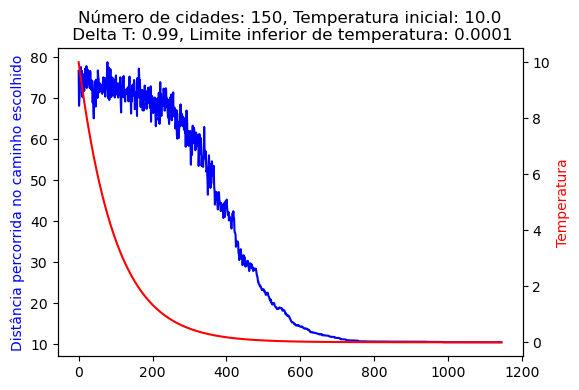

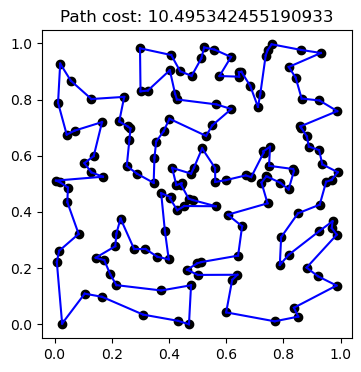

In [6]:
temperature: np.float_ = 10.0
delta_t: np.float_ = 0.99
temperature_inferior_limit: np.float_ = 0.0001

path, path_cost, nodes, distances, temperatures = tsp(number_of_cities=NUMBER_OF_CITIES, temperature=temperature, delta_t=0.99, temperature_inferior_limit=0.0001)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

In [15]:
import networkx as nx
current_path = nx.algorithms.approximation.traveling_salesman.christofides(nx.from_numpy_array(GRAPH))
edges: npt.NDArray[np.int_] = np.append(np.lib.stride_tricks.sliding_window_view(current_path, 2), [[current_path[-1], current_path[0]]], axis=0)
current_path_cost: np.float_ = np.sum([GRAPH[i, j] for i, j in edges])
current_path_cost

10.562274915533628

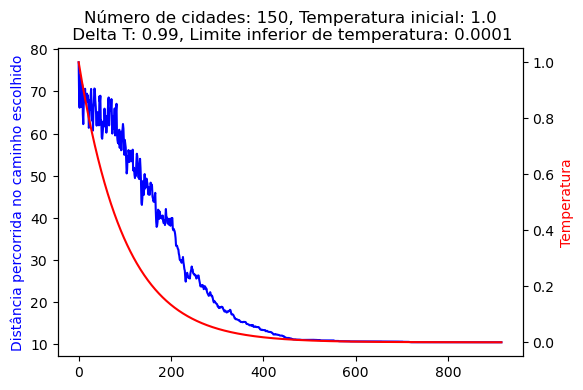

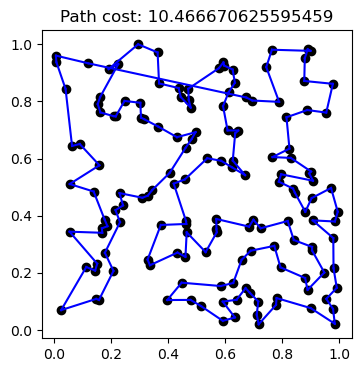

In [ ]:
temperature: np.float_ = 1.0
delta_t: np.float_ = 0.99
temperature_inferior_limit: np.float_ = 0.0001

path, path_cost, nodes, distances, temperatures = tsp(number_of_cities=NUMBER_OF_CITIES, temperature=temperature, delta_t=0.99, temperature_inferior_limit=0.0001)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

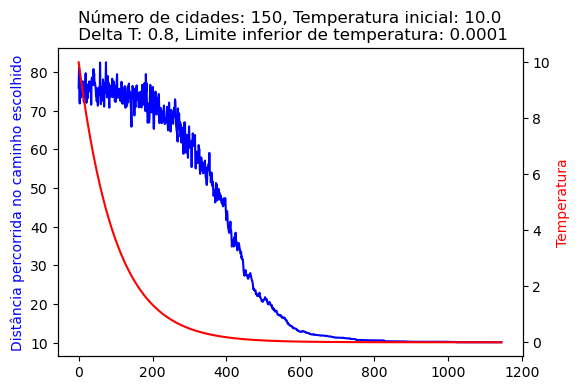

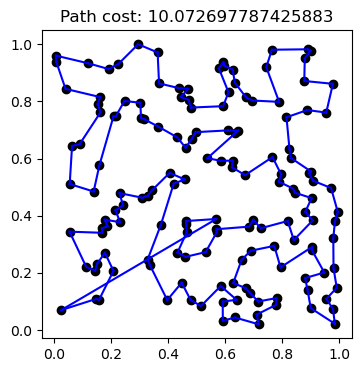

In [ ]:
temperature: np.float_ = 10.0
delta_t: np.float_ = 0.8
temperature_inferior_limit: np.float_ = 0.0001

path, path_cost, nodes, distances, temperatures = tsp(number_of_cities=NUMBER_OF_CITIES, temperature=temperature, delta_t=0.99, temperature_inferior_limit=0.0001)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

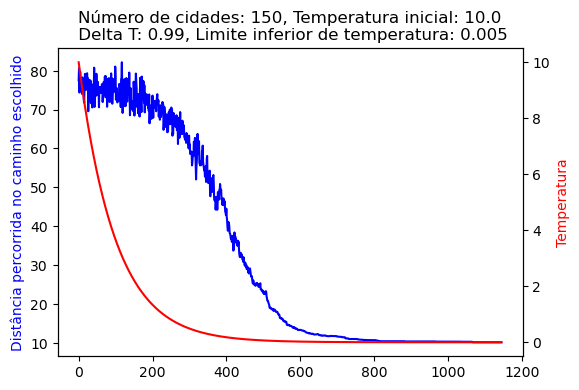

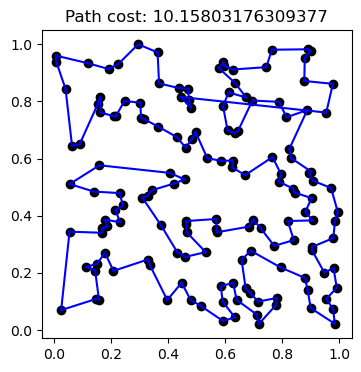

In [ ]:
temperature: np.float_ = 10.0
delta_t: np.float_ = 0.99
temperature_inferior_limit: np.float_ = 0.005

path, path_cost, nodes, distances, temperatures = tsp(number_of_cities=NUMBER_OF_CITIES, temperature=temperature, delta_t=0.99, temperature_inferior_limit=0.0001)
plot_distance_temperature(distances=distances, temperatures=temperatures, number_of_cities=NUMBER_OF_CITIES, initial_temperature=temperature, delta_t=delta_t, temperature_inferior_limit=temperature_inferior_limit)
plot_path(nodes=nodes, path=path, path_cost=path_cost)

In [ ]:
a = np.arange(10)
a[2:4]

array([2, 3])